Molly Szeman / ALY6020 / Final Project / June 25, 2024

Import packages

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from scipy.stats import norm

Upload the csv file

In [3]:
from google.colab import files
uploaded = files.upload()

Saving nba_salaries.csv to nba_salaries.csv


Read the csv into a data frame, print head of the df to preview

In [4]:
df = pd.read_csv('nba_salaries.csv')
print(df.head())

   Unnamed: 0        Player Name    Salary Position  Age     Team  GP  GS  \
0           0      Stephen Curry  48070014       PG   34      GSW  56  56   
1           1          John Wall  47345760       PG   32      LAC  34   3   
2           2  Russell Westbrook  47080179       PG   34  LAL/LAC  73  24   
3           3       LeBron James  44474988       PF   38      LAL  55  54   
4           4       Kevin Durant  44119845       PF   34  BRK/PHO  47  47   

     MP    FG  ...  ORB  DRB  TRB  AST  STL  BLK  TOV   PF   PTS  \
0  34.7  10.0  ...  0.7  5.4  6.1  6.3  0.9  0.4  3.2  2.1  29.4   
1  22.2   4.1  ...  0.4  2.3  2.7  5.2  0.8  0.4  2.4  1.7  11.4   
2  29.1   5.9  ...  1.2  4.6  5.8  7.5  1.0  0.5  3.5  2.2  15.9   
3  35.5  11.1  ...  1.2  7.1  8.3  6.8  0.9  0.6  3.2  1.6  28.9   
4  35.6  10.3  ...  0.4  6.3  6.7  5.0  0.7  1.4  3.3  2.1  29.1   

   Player-additional  
0          curryst01  
1           walljo01  
2          westbru01  
3          jamesle01  
4          du

# Data dictionary

- Unnamed (int64) - index column to be removed
- Player Name (object) - name of the player
- Salary (int64) - player's annual salary in USD
- Position (object) - player's basketball position
- Age (int64) - player's age during the season in years
- Team (object) - player's team at season's end
- GP (int64) - number of games played during the season
- GS (int64) - number of games started during the season
- MP (float64) - average number of minutes played per game
- FG (float64) - average number of field goals made per game (two- and three-pointers combined)
- FGA (float64) - average number of field goal attempts per game
- FG% (float64) - field goal percentage (made / attempts)
- 3P (float64) - average number three-point field goals made per game
- 3PA (float64) - average number of three-point attempts per game
- 3P% (float64) - three-point percentage (made / attempts)
- 2P (float64) - average number of two-pointers made per game
- 2PA (float64) - average number of two-point attempts per game
- 2P% (float64) - two-point percentage (made / attempts)
- eFG% (float64) - effective field goal percentage - adjusted percentage that considers the higher point value of three-pointers
- FT (float64) - average number of free throws made per game
- FTA (float64) - average number of free throw attempts per game
- FT% (float64) - free throw percentage (made / attempts)
- ORB (float64) - average offensive rebounds per game
- DRB (float64) - average defensive rebounds per game
- TRB (float64) - average total rebounds per game (ORB + DRB)
- AST (float64) - average assists per game
- STL (float64) - average steals per game
- BLK (float64) - average blocks per game
- TOV (float64) - average turnovers per game
- PF (float64) - average personal fouls per game
- PTS (float64) - average points per game
- Player-additional (object) - alias for player name





> * TOV and PF are statistics indicating negative performance, and desired totals are lower
* all other statistics indicate positive performance, and desired totals are higher




# Data exploration and cleaning

Determine the number of rows and columns

Print info on missing data

In [5]:
# Get the number of rows and columns
num_rows, num_columns = df.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

#get missing values and type of data in each column
print(df.info())

Number of rows: 467
Number of columns: 32
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         467 non-null    int64  
 1   Player Name        467 non-null    object 
 2   Salary             467 non-null    int64  
 3   Position           467 non-null    object 
 4   Age                467 non-null    int64  
 5   Team               467 non-null    object 
 6   GP                 467 non-null    int64  
 7   GS                 467 non-null    int64  
 8   MP                 467 non-null    float64
 9   FG                 467 non-null    float64
 10  FGA                467 non-null    float64
 11  FG%                466 non-null    float64
 12  3P                 467 non-null    float64
 13  3PA                467 non-null    float64
 14  3P%                454 non-null    float64
 15  2P                 467 non-null 

There are 4 columns with categorical data and 28 columns with numeric data.
There are a few missing entries in FG% (1), 3P% (13), 2P%(4), eFG%(1), FT% (23).  Since these are all columns representing percentages, I will see what they look like, since the player may not have taken any of that type of shot, so it should be a 0.

In [6]:
# Find rows with missing entries in any of the specified columns
cols_to_check = ['FG', 'FGA','FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%']
rows_with_missing = df[df[cols_to_check].isnull().any(axis=1)]

# Print only the specified columns of the rows with missing entries
print("Columns FG%, 3P%, 2P%, eFG%, FT% of rows with missing entries:")
print(rows_with_missing[cols_to_check])

Columns FG%, 3P%, 2P%, eFG%, FT% of rows with missing entries:
      FG  FGA    FG%   3P  3PA    3P%   2P  2PA    2P%   eFG%   FT  FTA    FT%
75   3.2  4.7  0.671  0.0  0.0    NaN  3.2  4.7  0.671  0.671  1.0  2.1  0.484
133  4.2  6.1  0.680  0.0  0.0    NaN  4.2  6.1  0.680  0.680  2.5  4.0  0.636
221  0.7  1.0  0.667  0.3  0.7  0.500  0.3  0.3  1.000  0.833  0.0  0.0    NaN
233  3.7  5.8  0.637  0.0  0.0    NaN  3.7  5.8  0.637  0.637  1.6  2.3  0.691
247  0.0  1.0  0.000  0.0  0.5  0.000  0.0  0.5  0.000  0.000  0.0  0.0    NaN
254  0.3  1.6  0.214  0.3  1.3  0.250  0.0  0.2  0.000  0.321  0.0  0.0    NaN
264  2.0  3.4  0.578  0.0  0.0    NaN  2.0  3.4  0.578  0.578  0.4  1.1  0.357
301  1.6  2.0  0.819  0.0  0.0    NaN  1.6  2.0  0.819  0.819  0.2  0.6  0.350
332  3.7  5.1  0.732  0.0  0.0    NaN  3.7  5.1  0.732  0.732  1.6  2.4  0.679
344  0.5  1.9  0.243  0.4  1.2  0.348  0.1  0.7  0.071  0.351  0.0  0.0    NaN
356  0.2  1.4  0.150  0.0  0.3  0.000  0.2  1.1  0.188  0.150  0.0  

My hunch was correct.  If the column FG% was NaN, it was because FG and FGA were both 0s.  All the % columns are calculated by dividing the made shots by the attempts, so if they were NaN, it was because the 2 columns it was computed from were 0s.  I will fill the NaNs with 0s.

In [7]:
# Replace NaNs with 0 in the entire DataFrame
df = df.fillna(0)

Drop columns that will not be used

In [8]:
# drop unnamed and player-additional because they aren't relevant to analysis
df = df.drop(columns=['Unnamed: 0', 'Player-additional'])

In [9]:
# drop Age because it's not relevant to player performance
df=df.drop(columns=['Age'])

In [10]:
# drop the columns that show the the number of made shots.
## (the columns that show the volume of shots (ie: FGA) and the accuracy (ie:FG%) will be used)
df = df.drop(columns=['FG', '2P', '3P', 'FT'])

In [11]:
# drop eFG%, FG, FGA, FG% because they're calculated using other variables
## FGA and FG% are based on 2PA and 3PA, eFG is based on all FG variables
### this will reduce multicollinearity
df=df.drop(columns = ['eFG%', 'FGA', 'FG%'])

In [12]:
# Add new column start% to capture how often the players starts when they play a game.
## then drop GS (games started) because we will already have the volume (GP) and percentage
# Calculate Start%
df['Start%'] = df['GS'] / df['GP']

# Drop GS column
df.drop(columns=['GS'], inplace=True)

Descriptive statistics of remaining columns

In [13]:
# Summary statistics for numeric columns
summary_stats = df.describe()
print("\nSummary statistics for numeric columns:")
print(summary_stats)


Summary statistics for numeric columns:
             Salary          GP          MP         3PA         3P%  \
count  4.670000e+02  467.000000  467.000000  467.000000  467.000000   
mean   8.416599e+06   48.233405   19.871306    2.792719    0.316041   
std    1.070812e+07   24.807740    9.548684    2.260794    0.140385   
min    5.849000e+03    1.000000    1.800000    0.000000    0.000000   
25%    1.782621e+06   31.000000   12.500000    1.000000    0.281000   
50%    3.722040e+06   55.000000   19.200000    2.400000    0.339000   
75%    1.063354e+07   68.500000   28.300000    4.150000    0.385500   
max    4.807001e+07   83.000000   41.000000   11.400000    1.000000   

              2PA         2P%         FTA         FT%         ORB         DRB  \
count  467.000000  467.000000  467.000000  467.000000  467.000000  467.000000   
mean     4.325268    0.528895    1.848394    0.716379    0.866809    2.662099   
std      3.571280    0.144124    1.896352    0.218290    0.746976    1.70798

Visuals of descriptive statistics

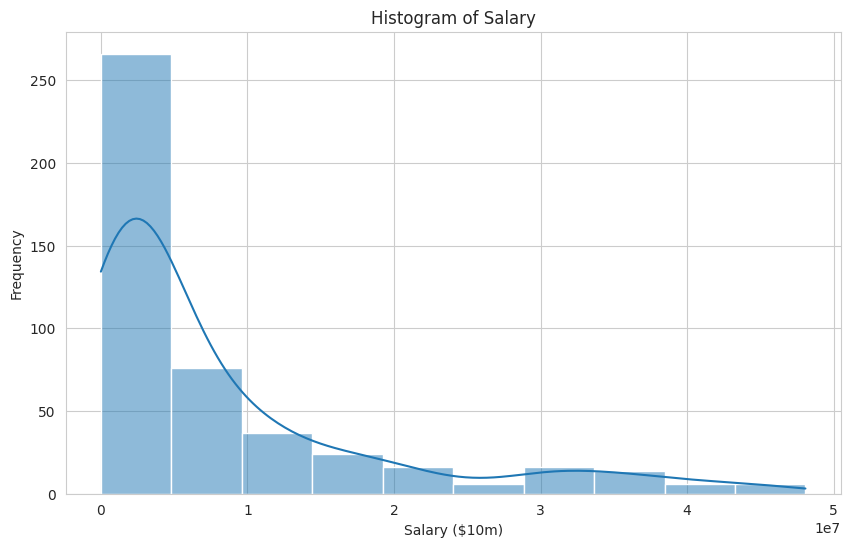

In [14]:
sns.set_style("whitegrid")

# Plotting the histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(df['Salary'], bins=10, kde=True)

# Adding titles and labels
plt.title('Histogram of Salary')
plt.xlabel('Salary ($10m)')
plt.ylabel('Frequency')

# Display the plot
plt.show()

Salary is highly skewed, with over 300 players earning less than $10 million

<Figure size 640x480 with 0 Axes>

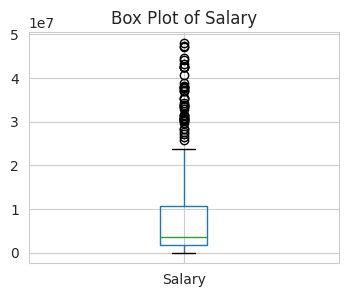

<Figure size 640x480 with 0 Axes>

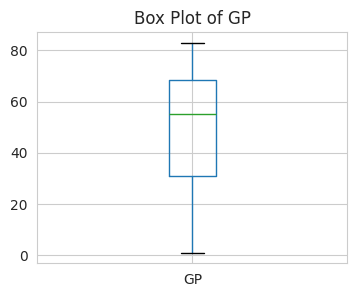

<Figure size 640x480 with 0 Axes>

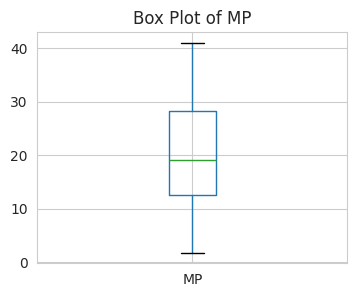

<Figure size 640x480 with 0 Axes>

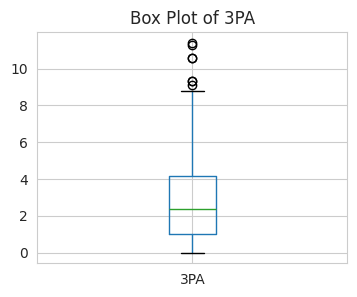

<Figure size 640x480 with 0 Axes>

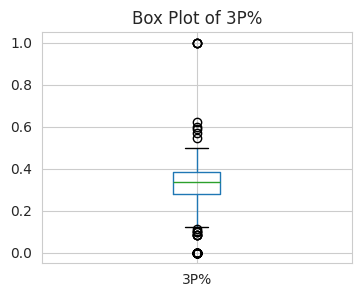

<Figure size 640x480 with 0 Axes>

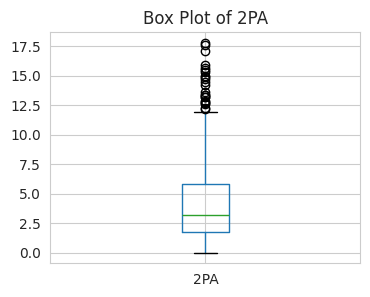

<Figure size 640x480 with 0 Axes>

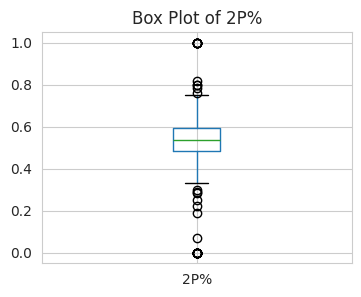

<Figure size 640x480 with 0 Axes>

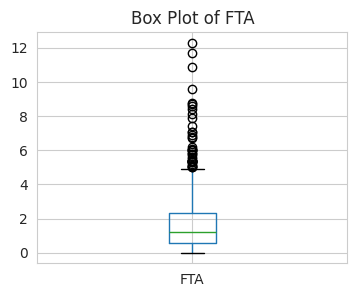

<Figure size 640x480 with 0 Axes>

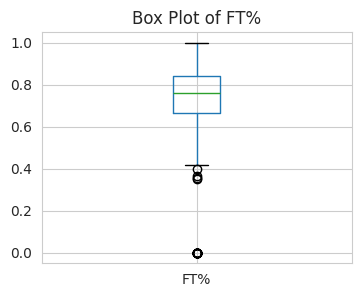

<Figure size 640x480 with 0 Axes>

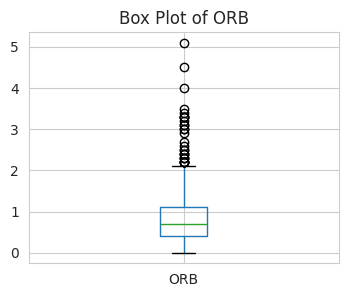

<Figure size 640x480 with 0 Axes>

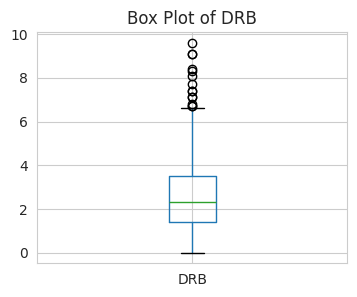

<Figure size 640x480 with 0 Axes>

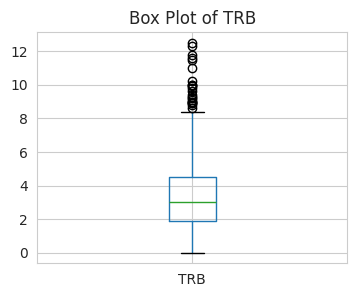

<Figure size 640x480 with 0 Axes>

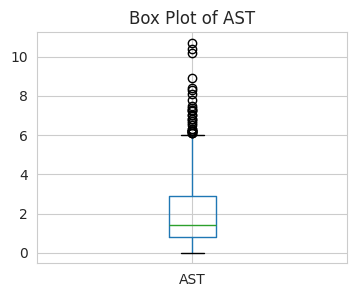

<Figure size 640x480 with 0 Axes>

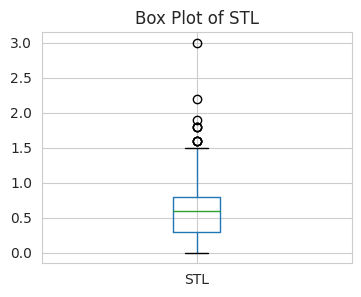

<Figure size 640x480 with 0 Axes>

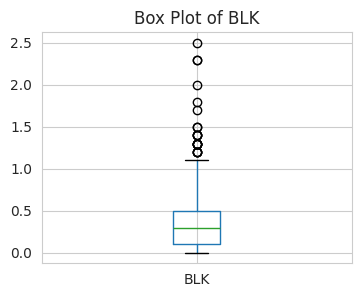

<Figure size 640x480 with 0 Axes>

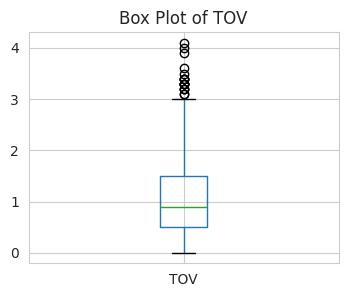

<Figure size 640x480 with 0 Axes>

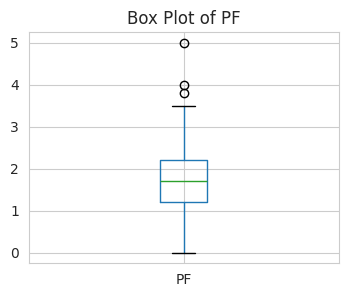

<Figure size 640x480 with 0 Axes>

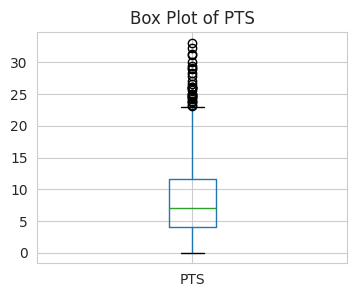

<Figure size 640x480 with 0 Axes>

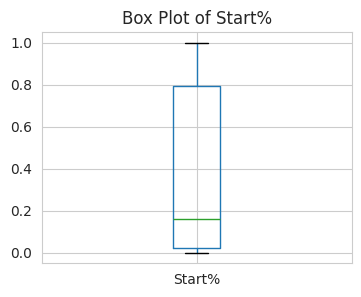

In [15]:
# Plot box plots for all numeric columns to look for outliers
numeric_columns = df.select_dtypes(include='number').columns

for column in numeric_columns:
    plt.figure()
    plt.figure(figsize=(4, 3))
    df.boxplot(column=column)
    plt.title(f'Box Plot of {column}')
    plt.show()

Almost all variables, including salary, the target variable, have some outliers, as shown by the mean being significantly higher than the median.
Since the dataset is small the outliers will be kept for the intial models. Removing outliers may result in an extremely small amount of data.

Fix the data related to position - remove combination positions so only the 5 standard positions remain (PG, SG, SF, PF, C)

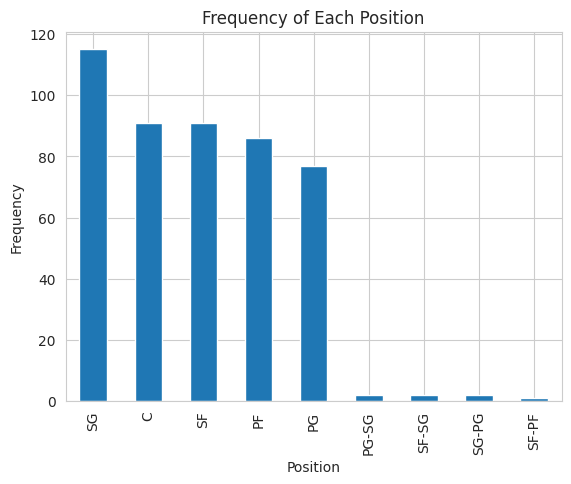

In [16]:
# Count the occurrences of each position
position_counts = df['Position'].value_counts()

# Plot the bar chart
position_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.title('Frequency of Each Position')

# Display the plot
plt.show()

There are 5 positions in basketball (SG, SF, C, PF, and PG).
In this data, 4 combination positions (PG-SG, SF-SG, SG-PG, SF-PF) have been created.
Since the data is small (467 rows) and there are only few instances of the combo positions, I will convert them to the first position listed in the combination (ie PG-SG will become PG).

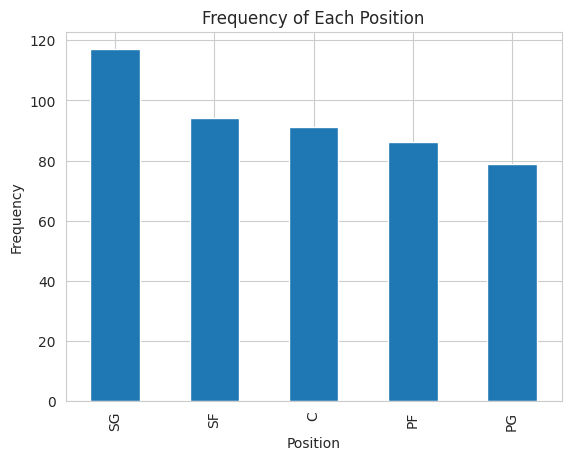

In [17]:
# Remove hyphen and characters after it in the "Position" column
df['Position'] = df['Position'].str.split('-').str[0]

# Count the occurrences of each position
position_counts = df['Position'].value_counts()

# Plot the bar chart
position_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.title('Frequency of Each Position')

# Display the plot
plt.show()

# 1: Linear Regression
can salary be predicted based on performance statistics?
what variables are important for predicting salary?

In [18]:
# drop categorical variables
# Drop GS column
df1 = df.drop(columns=['Position', 'Team', 'Player Name'])

          Salary        GP        MP       3PA       3P%       2PA       2P%  \
Salary  1.000000  0.341707  0.642099  0.491569  0.098320  0.681926  0.074727   
GP      0.341707  1.000000  0.639889  0.401956  0.145196  0.444550  0.195306   
MP      0.642099  0.639889  1.000000  0.698818  0.199110  0.798854  0.133041   
3PA     0.491569  0.401956  0.698818  1.000000  0.356797  0.454883 -0.035971   
3P%     0.098320  0.145196  0.199110  0.356797  1.000000  0.061778 -0.032441   
2PA     0.681926  0.444550  0.798854  0.454883  0.061778  1.000000  0.128997   
2P%     0.074727  0.195306  0.133041 -0.035971 -0.032441  0.128997  1.000000   
FTA     0.668638  0.394685  0.705301  0.439221  0.066738  0.886626  0.113694   
FT%     0.225000  0.380186  0.364353  0.368089  0.236547  0.249109  0.166345   
ORB     0.219490  0.305178  0.360212 -0.150888 -0.264870  0.399034  0.302313   
DRB     0.576596  0.492522  0.749694  0.324368 -0.000224  0.731634  0.238841   
TRB     0.503633  0.469432  0.679031  0.

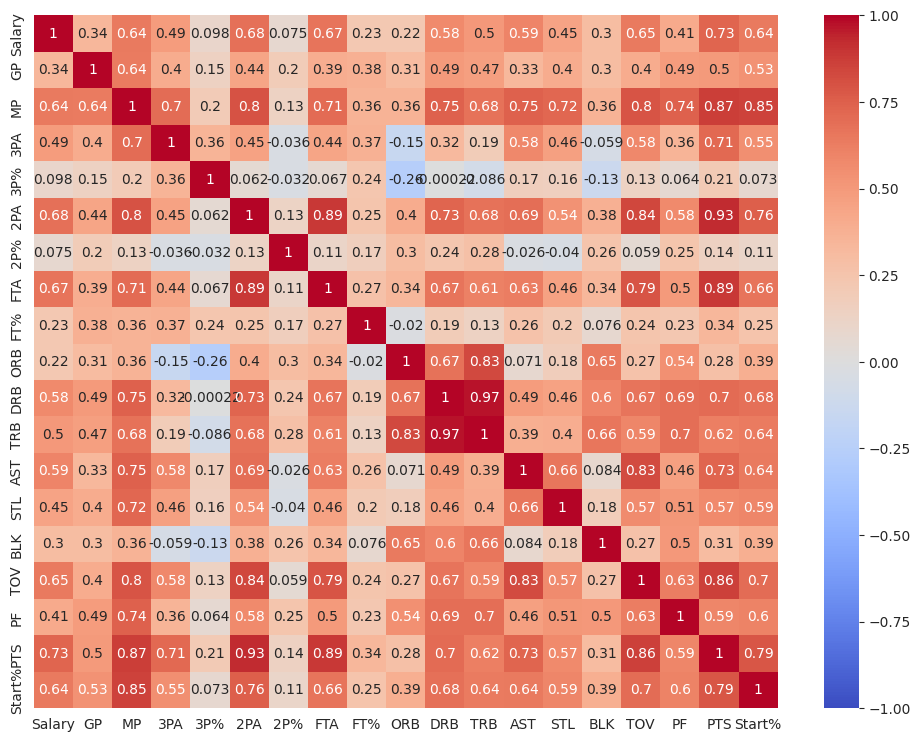

In [19]:
# Compute the correlation matrix
correlation_matrix = df1.corr()

# Display the correlation matrix
print(correlation_matrix)

# Create a heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm', center=0)

# Display the heatmap
plt.show()

There are no significant negative correlations.

Significant positive correlations (>.8) include:
- TOV - MP (.8)
- MP - 2PA (.8)
- TOV - AST (.83)
- TRB - ORB (.83)
- TOV - 2PA (.84)
- Start% - MP (.85)
- PTS - TOV (.86)
- PTS - MP (.87)
- FTA - 2PA (.89)
- FTA - PTS (.89)
- PTS - 2PA (.93)
- TRB - DRB (.97)

Many of the correlations indicate multicollinearity. Example, TRB and DRB have a high correlation, and which is due to TRB including DRB.

Interestingly, FTA correlates highly with 2PA (.89), but not 3PA (.44).

Model 1: First attempt Linear regression

In [20]:
# run the linear regression
# Create X and y
X = df1.drop(columns=['Salary'])
y = df1['Salary']

# Scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=63)

# Add constant to X_train
X_train_with_constant = sm.add_constant(X_train)

# Align indices
y_train = y_train.reset_index(drop=True)
X_train_with_constant = X_train_with_constant.reset_index(drop=True)

# Run the model on training data
model = sm.OLS(y_train, X_train_with_constant).fit()
print(model.summary())

# Evaluate the model on test data
X_test_with_constant = sm.add_constant(X_test)
y_pred = model.predict(X_test_with_constant)

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     28.49
Date:                Tue, 24 Jun 2025   Prob (F-statistic):           6.44e-58
Time:                        17:41:14   Log-Likelihood:                -6389.5
No. Observations:                 373   AIC:                         1.282e+04
Df Residuals:                     354   BIC:                         1.289e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.222e+06   3.55e+05     23.165      0.0

The model is so so at predicting salary (R^2 = .592), slightly more accurate than random chance.  
The significant variables were MP (minutes played), BLK (blocks), PTS (points), and Start% (percentage of games played that they started), as shown by the value < 0.05.

Model 2: Remove salary outliers, drop some variables, and rerun linear regression

In [21]:
print(df1.head())

     Salary  GP    MP   3PA    3P%   2PA    2P%  FTA    FT%  ORB  DRB  TRB  \
0  48070014  56  34.7  11.4  0.427   8.8  0.579  5.0  0.915  0.7  5.4  6.1   
1  47345760  34  22.2   3.2  0.303   6.7  0.459  3.3  0.681  0.4  2.3  2.7   
2  47080179  73  29.1   3.9  0.311   9.7  0.487  4.3  0.656  1.2  4.6  5.8   
3  44474988  55  35.5   6.9  0.321  15.3  0.580  5.9  0.768  1.2  7.1  8.3   
4  44119845  47  35.6   4.9  0.404  13.4  0.617  7.1  0.919  0.4  6.3  6.7   

   AST  STL  BLK  TOV   PF   PTS    Start%  
0  6.3  0.9  0.4  3.2  2.1  29.4  1.000000  
1  5.2  0.8  0.4  2.4  1.7  11.4  0.088235  
2  7.5  1.0  0.5  3.5  2.2  15.9  0.328767  
3  6.8  0.9  0.6  3.2  1.6  28.9  0.981818  
4  5.0  0.7  1.4  3.3  2.1  29.1  1.000000  


In [22]:
# # Calculate the interquartile range (IQR) for Salary

Q1 = df1['Salary'].quantile(0.25)
Q3 = df1['Salary'].quantile(0.75)
IQR = Q3 - Q1

# Filter Salary to 1.5x IQR
filtered_df = df1[(df1['Salary'] >= Q1 - 1.5 * IQR) & (df1['Salary'] <= Q3 + 1.5 * IQR)]


# only keep most common basketball stats (minutes, points, rebounds, assists, steals, turnovers)
filtered_df.drop(columns=[ 'GP', '3PA', '3P%', '2PA', '2P%', 'FTA', 'FT%', 'ORB', 'DRB', 'PF'], inplace=True)

# Print the filtered DataFrame
print("Filtered DataFrame based on 1.5x IQR")
print(filtered_df)

Filtered DataFrame based on 1.5x IQR
       Salary    MP   TRB  AST  STL  BLK  TOV   PTS    Start%
48   23760000  35.5  10.0  4.1  0.6  0.3  2.8  25.1  1.000000
49   23500000  30.0   6.5  1.2  0.6  1.0  1.1  13.1  1.000000
50   22680000  30.3   2.7  6.7  1.1  0.2  1.5  11.9  0.985075
51   22600000  26.0   4.2  3.7  0.7  0.3  1.5  14.9  0.000000
52   22321429  35.0   2.6  4.1  0.7  0.2  2.1  21.1  1.000000
..        ...   ...   ...  ...  ...  ...  ...   ...       ...
462     35096  22.3   3.8  1.0  0.5  1.3  1.0   4.3  0.000000
463     32795   5.6   0.8  1.0  0.0  0.4  0.2   1.0  0.000000
464     32171  18.7   2.0  1.7  0.7  0.0  0.0   8.0  0.000000
465      5849  35.0   9.0  7.0  0.0  1.0  4.0  16.0  0.000000
466      5849  41.0   4.0  7.0  3.0  0.0  2.0   3.0  0.000000

[419 rows x 9 columns]


/tmp/ipython-input-22-1467448492.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=[ 'GP', '3PA', '3P%', '2PA', '2P%', 'FTA', 'FT%', 'ORB', 'DRB', 'PF'], inplace=True)


48 high salary entries were removed, leaving 419 rows of data.
Now try the linear regression again:

In [23]:
# Create X and y
X = filtered_df.drop(columns=['Salary'])
y = filtered_df['Salary']

# Scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=63)

# Add constant to X_train
X_train_with_constant = sm.add_constant(X_train)

# Align indices
y_train = y_train.reset_index(drop=True)
X_train_with_constant = X_train_with_constant.reset_index(drop=True)

# Run the model on training data
model = sm.OLS(y_train, X_train_with_constant).fit()
print(model.summary())

# Evaluate the model on test data
X_test_with_constant = sm.add_constant(X_test)
y_pred = model.predict(X_test_with_constant)

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     25.22
Date:                Tue, 24 Jun 2025   Prob (F-statistic):           3.44e-30
Time:                        17:41:25   Log-Likelihood:                -5593.4
No. Observations:                 335   AIC:                         1.120e+04
Df Residuals:                     326   BIC:                         1.124e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.263e+06    2.4e+05     21.953      0.0

This model was even worse! (R^2 = .382)
PTS and Start % were the only significant variables (where p < 0.05).

I will try to transform salary into a log and retry the regression.

In [24]:
# Create X and log-transformed y
X = df1.drop(columns=['Salary'])
y = np.log(df1['Salary'] + 1)

# Scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=63)

# Add constant to X_train
X_train_with_constant = sm.add_constant(X_train)

# Align indices
y_train = y_train.reset_index(drop=True)
X_train_with_constant = X_train_with_constant.reset_index(drop=True)

# Run the model on training data (log-transformed y)
model = sm.OLS(y_train, X_train_with_constant).fit()
print(model.summary())

# Predict on test data
X_test_with_constant = sm.add_constant(X_test)
y_pred_log = model.predict(X_test_with_constant)

# Convert predictions back to original scale
y_pred_original = np.exp(y_pred_log) - 1


                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     24.61
Date:                Tue, 24 Jun 2025   Prob (F-statistic):           1.13e-51
Time:                        17:41:29   Log-Likelihood:                -545.18
No. Observations:                 373   AIC:                             1128.
Df Residuals:                     354   BIC:                             1203.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.0440      0.056    270.364      0.0

This model is not very accurate either (R^2 = .556)

Predicting player salaries based soley on their performance statistics does not seem to be accurate.

Next, I will create a model to identify undervalued players.

# 2. Classification

In [25]:
# set threshold for high vs low salary
## high salary will be considered greater than 10.6 million (the 75th %tile)
df['HighSalary'] = (df['Salary'] >= df['Salary'].quantile(0.75)).astype(int)

print(df.head())

         Player Name    Salary Position     Team  GP    MP   3PA    3P%   2PA  \
0      Stephen Curry  48070014       PG      GSW  56  34.7  11.4  0.427   8.8   
1          John Wall  47345760       PG      LAC  34  22.2   3.2  0.303   6.7   
2  Russell Westbrook  47080179       PG  LAL/LAC  73  29.1   3.9  0.311   9.7   
3       LeBron James  44474988       PF      LAL  55  35.5   6.9  0.321  15.3   
4       Kevin Durant  44119845       PF  BRK/PHO  47  35.6   4.9  0.404  13.4   

     2P%  ...  DRB  TRB  AST  STL  BLK  TOV   PF   PTS    Start%  HighSalary  
0  0.579  ...  5.4  6.1  6.3  0.9  0.4  3.2  2.1  29.4  1.000000           1  
1  0.459  ...  2.3  2.7  5.2  0.8  0.4  2.4  1.7  11.4  0.088235           1  
2  0.487  ...  4.6  5.8  7.5  1.0  0.5  3.5  2.2  15.9  0.328767           1  
3  0.580  ...  7.1  8.3  6.8  0.9  0.6  3.2  1.6  28.9  0.981818           1  
4  0.617  ...  6.3  6.7  5.0  0.7  1.4  3.3  2.1  29.1  1.000000           1  

[5 rows x 23 columns]


In [26]:
# drop team and player (categorical) and salary, since we are now using the HighSalary classification
df2 = df.drop(columns=['Team', 'Player Name', 'Salary'])

In [27]:
# 1 hot encode Position
df2 = pd.get_dummies(df2, columns=['Position'], prefix='P')

print(df2.head())

   GP    MP   3PA    3P%   2PA    2P%  FTA    FT%  ORB  DRB  ...  TOV   PF  \
0  56  34.7  11.4  0.427   8.8  0.579  5.0  0.915  0.7  5.4  ...  3.2  2.1   
1  34  22.2   3.2  0.303   6.7  0.459  3.3  0.681  0.4  2.3  ...  2.4  1.7   
2  73  29.1   3.9  0.311   9.7  0.487  4.3  0.656  1.2  4.6  ...  3.5  2.2   
3  55  35.5   6.9  0.321  15.3  0.580  5.9  0.768  1.2  7.1  ...  3.2  1.6   
4  47  35.6   4.9  0.404  13.4  0.617  7.1  0.919  0.4  6.3  ...  3.3  2.1   

    PTS    Start%  HighSalary    P_C   P_PF   P_PG   P_SF   P_SG  
0  29.4  1.000000           1  False  False   True  False  False  
1  11.4  0.088235           1  False  False   True  False  False  
2  15.9  0.328767           1  False  False   True  False  False  
3  28.9  0.981818           1  False   True  False  False  False  
4  29.1  1.000000           1  False   True  False  False  False  

[5 rows x 24 columns]


In [28]:
# new train test split based on new data
X = df2.drop(columns=['HighSalary'])
y = df2['HighSalary']
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=63)

In [29]:
# xg boost - looking for false positives
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=500, learning_rate=1.0)
gbrt.fit(X_train, y_train)
y_pred = gbrt.predict(X_test) > 0.5
print('precision: {:.2}, recall: {:.2}'.format(
    precision_score(y_test, y_pred),
    recall_score(y_test, y_pred),
))

precision: 0.73, recall: 0.62


In [30]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[62  6]
 [10 16]]


Precision = 0.73, meaning of all the high salary predictions, 73% were correct.
Recall = 0.62, meaning the model identified 62% of the actual positives for high salary.

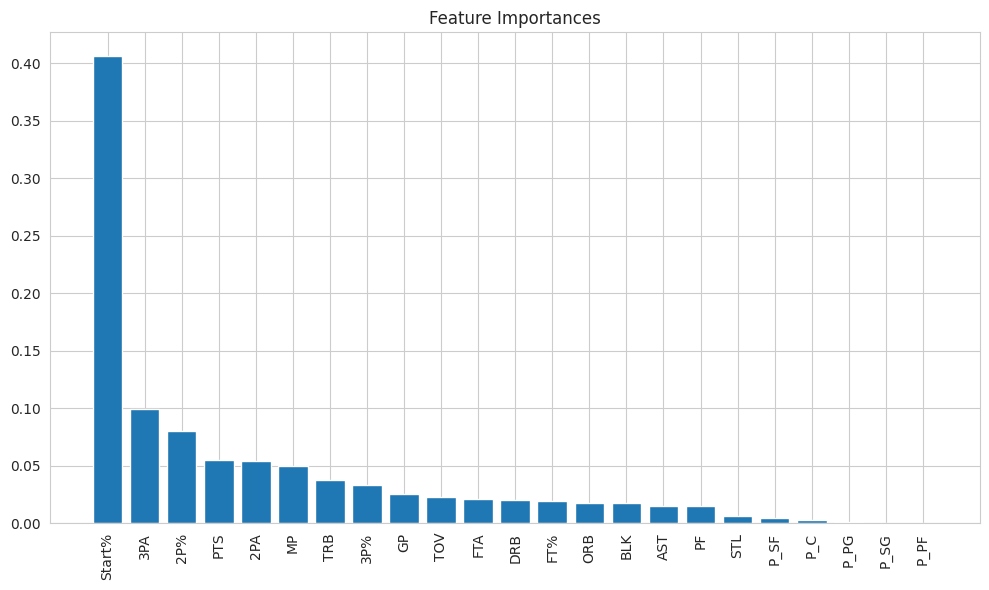

In [31]:
# Get feature importances
importances = gbrt.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

This model performed good but not great at identifying high salary players based on their performance statistics. However, since it used a train-test split, not all players were in the test pool, so the false positives identified were not inclusive of the whole pool of players, thus it is not helpful at identifying the undervalued players from the entire pool. Since the model performed well enough, I will use the xg-boost model again with cross validation, so all players will be in the prediction set.

To identify undervalued players, run the xgboost model and all the data (467 players) using cross validation method, then look for false positives (who does the model think are high earners that are actually low earners?)

In [32]:
# run the xgboost model with all data, no train test split

# Initialize XGBoost classifier
model = xgb.XGBClassifier()

# Train the model on the entire dataset
model.fit(X, y)

# Predicting on the same dataset (not recommended for evaluation)
predictions = model.predict(X)

In [35]:
# Perform cross-validation - accuracy
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {scores}')
print(f'Mean Accuracy: {scores.mean()}')

# Perform cross-validation - precision
scores = cross_val_score(model, X, y, cv=5, scoring='precision')
print(f'Cross-Validation Precision Scores: {scores}')
print(f'Mean Precision: {scores.mean()}')

# Perform cross-validation - recall
scores = cross_val_score(model, X, y, cv=5, scoring='recall')
print(f'Cross-Validation Recall Scores: {scores}')
print(f'Mean Recall: {scores.mean()}')

Cross-Validation Accuracy Scores: [0.72340426 0.87234043 0.84946237 0.83870968 0.82795699]
Mean Accuracy: 0.8223747426218256
Cross-Validation Precision Scores: [0.475      0.73076923 0.84615385 1.         0.76923077]
Mean Precision: 0.7642307692307692
Cross-Validation Recall Scores: [0.79166667 0.79166667 0.47826087 0.34782609 0.43478261]
Mean Recall: 0.5688405797101449


The model was accurate (mean accuracy = 0.82) at predicting salary classification (high or low) based on performance statistics.

The mean precision was also high (0.76), indicating that 76% of the high salary predictions were accurate.

The recall score was lower (0.56), indicating the model only accurately identified 56% of high salary earners.

The false positives are indicative of players who perform like high earners but actually have low salaries. These are the players teams should target to build their teams.

In [40]:
# Get cross-validated predictions
cv_predictions = cross_val_predict(model, X, y, cv=5)

# Identify false positives
false_positives = (cv_predictions == 1) & (y == 0)
false_positive_rows = df[false_positives]

# Filter by GP >= 21 (only include players who played in approx 25% of the season)
false_positive_rows = false_positive_rows[false_positive_rows['GP'] >= 21]

print("False Positive Rows:")
print(false_positive_rows)

False Positive Rows:
           Player Name    Salary Position     Team  GP    MP   3PA    3P%  \
121        Ivica Zubac  10123457        C      LAC  76  28.6   0.0  0.000   
123         Alec Burks  10012800       SG      DET  51  22.0   4.7  0.414   
124    De'Andre Hunter   9835881       SF      ATL  67  31.7   4.3  0.350   
128        Jalen Green   9441840       SG      HOU  76  34.2   7.3  0.338   
129       Jakob Poeltl   9398148        C  SAS/TOR  72  26.5   0.0  0.000   
132       Monte Morris   9125000       PG      WAS  62  27.3   3.3  0.382   
136      Grayson Allen   8925000       SG      MIL  72  27.4   5.1  0.399   
137     Darius Garland   8920794       PG      CLE  69  35.5   6.0  0.410   
142        LaMelo Ball   8623920       PG      CHO  36  35.2  10.6  0.376   
144        Evan Mobley   8478720       PF      CLE  79  34.4   1.3  0.216   
149      Keegan Murray   8008440       SF      SAC  80  29.8   6.3  0.411   
150       Kevon Looney   8000000        C      GSW  82 

The false positives are the 29 players with low salaries that the model predicted as high salary players (who participated in at least 25% of the season's games). These are high performing players with relatively low salaries.

Plot feature importance for salary classification

Feature Importance:
   Feature  Importance
18     P_C    0.000000
19    P_PF    0.000000
8      ORB    0.010437
10     TRB    0.017970
14     TOV    0.019925
13     BLK    0.021386
7      FT%    0.023385
5      2P%    0.023800
15      PF    0.029162
0       GP    0.030541
3      3P%    0.030698
21    P_SF    0.031398
11     AST    0.031595
6      FTA    0.032334
12     STL    0.033201
4      2PA    0.034675
22    P_SG    0.034978
9      DRB    0.037081
1       MP    0.038193
20    P_PG    0.043731
16     PTS    0.071846
2      3PA    0.082289
17  Start%    0.321376


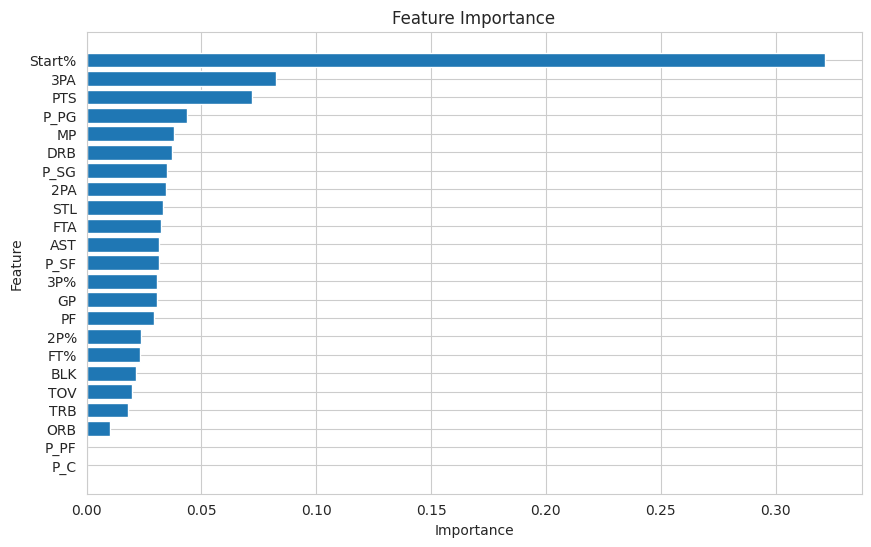

In [41]:
# Get feature importance
importance = model.feature_importances_
# indices = np.argsort(importances)[::-1]
features = X.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})

# Sort feature importance by Importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

print("Feature Importance:")
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

The most importance variables for predicting salary were Start% (percentage of games started), followed by 3PA (three-point attempts), PTS (points), and P_PG (position = point guard).

# 3. Linear Interpolation

Next - rank players based on their aggregate statistics, determine an assigned salary based on performance, and determine which players had the biggest differences between actual and assigned salary.

In [36]:
print(df.head())

         Player Name    Salary Position     Team  GP    MP   3PA    3P%   2PA  \
0      Stephen Curry  48070014       PG      GSW  56  34.7  11.4  0.427   8.8   
1          John Wall  47345760       PG      LAC  34  22.2   3.2  0.303   6.7   
2  Russell Westbrook  47080179       PG  LAL/LAC  73  29.1   3.9  0.311   9.7   
3       LeBron James  44474988       PF      LAL  55  35.5   6.9  0.321  15.3   
4       Kevin Durant  44119845       PF  BRK/PHO  47  35.6   4.9  0.404  13.4   

     2P%  ...  DRB  TRB  AST  STL  BLK  TOV   PF   PTS    Start%  HighSalary  
0  0.579  ...  5.4  6.1  6.3  0.9  0.4  3.2  2.1  29.4  1.000000           1  
1  0.459  ...  2.3  2.7  5.2  0.8  0.4  2.4  1.7  11.4  0.088235           1  
2  0.487  ...  4.6  5.8  7.5  1.0  0.5  3.5  2.2  15.9  0.328767           1  
3  0.580  ...  7.1  8.3  6.8  0.9  0.6  3.2  1.6  28.9  0.981818           1  
4  0.617  ...  6.3  6.7  5.0  0.7  1.4  3.3  2.1  29.1  1.000000           1  

[5 rows x 23 columns]


In [37]:
# create a performance metric based on their statistics:
##  add up crucial statistics for a new performance metric (PM_stats): (points, blocks, steals, assists, rebounds, subtract turnovers and fouls (negative stats), and divide the total by minutes played)
# PM_stats = (PTS + BLK + STL + AST + TRB - TOV - PF)/ MP
df['PM_stats'] = (df['PTS'] + df['BLK'] + df['STL'] + df['AST'] + df['TRB'] - df['TOV'] - df['PF'])/ df['MP']

In [38]:
salary_max = df['Salary'].max()
salary_min = df['Salary'].min()

In [39]:
# scale the performance metric
scaler = MinMaxScaler()
df['PM_stats_normalized'] = scaler.fit_transform(df[['PM_stats']])

In [59]:
# # Assign salary based on normalized PM
# # Using linear interpolation between salary_min and salary_max, ensure the minimum does not go below 0
df['assigned_salary'] = (df['PM_stats_normalized'] * (salary_max - salary_min) + salary_min).clip(lower=0)



In [60]:
#create salary_diff to determine the difference in salary and assigned salary
df['salary_diff'] =  df['assigned_salary'] - df['Salary']

In [61]:
# Filter by GP >= 21 (approx 25% of the season)
df_filtered = df[df['GP'] >= 21]

# print the top 10 - players with greatest increase from actual salary to assigned salary (ie: most underpayed players based on this year's stats)
df_sorted = df_filtered.sort_values(by='salary_diff', ascending=False)

print(df_sorted.head(10))

           Player Name   Salary Position     Team  GP    MP  3PA    3P%  2PA  \
395        Moses Brown   824041        C  BRK/LAC  36   8.2  0.0  0.000  2.7   
418         Luka Garza   508891        C      MIN  28   8.7  1.4  0.359  2.8   
216  Tyrese Haliburton  4215120       PG      IND  56  33.6  7.2  0.400  7.8   
309       Desmond Bane  2130240       SG      MEM  58  31.7  7.0  0.408  9.2   
391          Kris Dunn  1000001       PG      UTA  22  25.8  1.6  0.472  8.2   
245     Andre Drummond  3200000        C      CHI  67  12.7  0.0  0.000  4.0   
330           Naz Reid  1930681        C      MIN  68  18.4  3.2  0.346  5.3   
324      Thomas Bryant  1968175        C  DEN/LAL  59  18.3  1.0  0.441  5.3   
298       Bones Hyland  2201520       PG  DEN/LAC  56  19.4  5.6  0.371  4.6   
272     Walker Kessler  2696400        C      UTA  74  23.0  0.0  0.333  5.6   

       2P%  ...   PF   PTS    Start%  HighSalary  PM_stats  \
395  0.635  ...  1.1   4.3  0.027778           0  0.89024

Determine which positions were most overpayed

  Position  Average_Salary_Diff
0        C         1.336453e+07
4       SG         1.137098e+07
1       PF         1.023030e+07
3       SF         9.069957e+06
2       PG         7.401982e+06


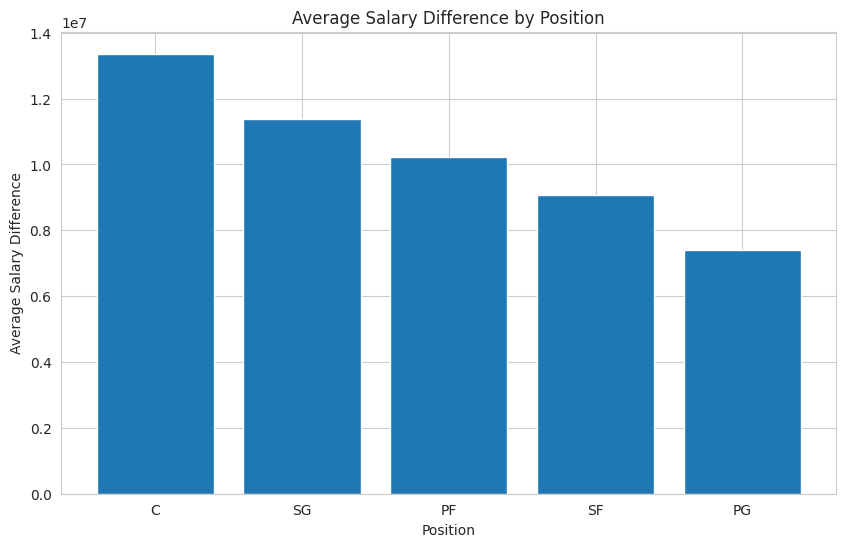

In [62]:
# Calculate the average salary_diff by Position
avg_salary_diff_by_position = df_sorted.groupby('Position')['salary_diff'].mean().reset_index()

# Rename the columns for clarity
avg_salary_diff_by_position.columns = ['Position', 'Average_Salary_Diff']

# Sort the table by Average_Salary_Diff in ascending order
avg_salary_diff_by_position_sorted = avg_salary_diff_by_position.sort_values(by='Average_Salary_Diff', ascending=False)

print(avg_salary_diff_by_position_sorted)

# Plot average salary difference by position
plt.figure(figsize=(10, 6))
plt.bar(avg_salary_diff_by_position_sorted['Position'], avg_salary_diff_by_position_sorted['Average_Salary_Diff'])
plt.xlabel('Position')
plt.ylabel('Average Salary Difference')
plt.title('Average Salary Difference by Position')
plt.show()

Centers have the greatest average salary difference, meaning their performance statistics indicated they should have higher salaries than they actually earned. Poitn guards are the lowest.

In [63]:
# Which players at each position overperform for their salary?
# Function to get top 3 players with the lowest salary_diff for each position
def get_top3_by_position(group):
    return group.nlargest(3, 'salary_diff')

# Apply the function to each group (each position)
top3_by_position = df_filtered.groupby('Position').apply(get_top3_by_position).reset_index(drop=True)

print(top3_by_position)

          Player Name   Salary Position     Team  GP    MP  3PA    3P%   2PA  \
0         Moses Brown   824041        C  BRK/LAC  36   8.2  0.0  0.000   2.7   
1          Luka Garza   508891        C      MIN  28   8.7  1.4  0.359   2.8   
2      Andre Drummond  3200000        C      CHI  67  12.7  0.0  0.000   4.0   
3       Chimezie Metu  1910860       PF      SAC  66  10.4  0.6  0.237   2.7   
4             Bol Bol  2200000       PF      ORL  70  21.5  1.6  0.265   5.2   
5         Josh Giddey  6287400       PF      OKC  76  31.1  3.1  0.325  11.6   
6   Tyrese Haliburton  4215120       PG      IND  56  33.6  7.2  0.400   7.8   
7           Kris Dunn  1000001       PG      UTA  22  25.8  1.6  0.472   8.2   
8        Bones Hyland  2201520       PG  DEN/LAC  56  19.4  5.6  0.371   4.6   
9      Keldon Johnson  3873024       SF      SAS  63  32.7  6.5  0.329  11.2   
10         Saddiq Bey  2959080       SF  DET/ATL  77  27.6  5.4  0.361   5.4   
11      Jalen Johnson  2792640       SF 

/tmp/ipython-input-63-3358980848.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top3_by_position = df_filtered.groupby('Position').apply(get_top3_by_position).reset_index(drop=True)


The top three players at each position who overperform for their salary. These players could be key targets to add to a team.

In [64]:
# The top three players at each position that overperform for their salary

# Keep only the specified columns
top3_by_position = top3_by_position[['Player Name', 'Position', 'Salary', 'assigned_salary', 'salary_diff']]

print(top3_by_position)

          Player Name Position   Salary  assigned_salary   salary_diff
0         Moses Brown        C   824041     2.584522e+07  2.502118e+07
1          Luka Garza        C   508891     2.551116e+07  2.500227e+07
2      Andre Drummond        C  3200000     2.599330e+07  2.279330e+07
3       Chimezie Metu       PF  1910860     2.226634e+07  2.035548e+07
4             Bol Bol       PF  2200000     2.161609e+07  1.941609e+07
5         Josh Giddey       PF  6287400     2.553189e+07  1.924449e+07
6   Tyrese Haliburton       PG  4215120     2.774526e+07  2.353014e+07
7           Kris Dunn       PG  1000001     2.408451e+07  2.308450e+07
8        Bones Hyland       PG  2201520     2.360436e+07  2.140284e+07
9      Keldon Johnson       SF  3873024     2.436865e+07  2.049562e+07
10         Saddiq Bey       SF  2959080     2.151282e+07  1.855374e+07
11      Jalen Johnson       SF  2792640     2.091967e+07  1.812703e+07
12       Desmond Bane       SG  2130240     2.538989e+07  2.325965e+07
13    

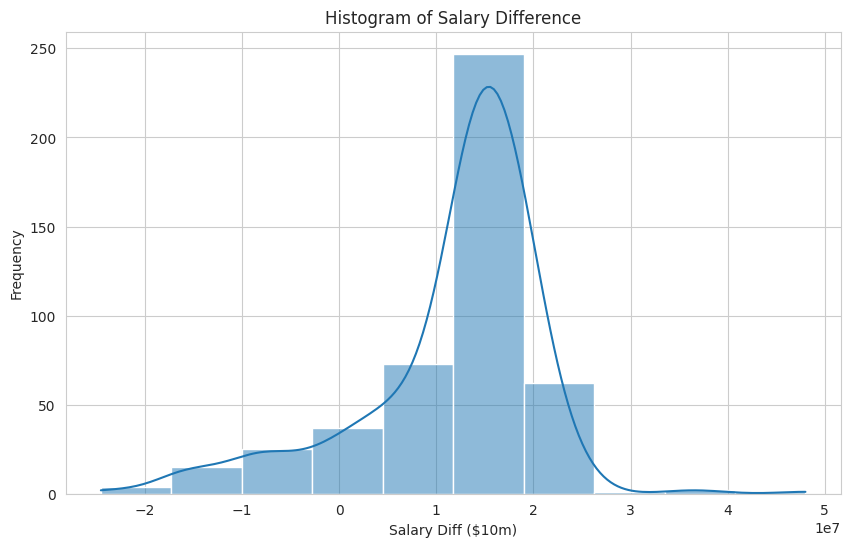

In [65]:
sns.set_style("whitegrid")

# Plotting the histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(df['salary_diff'], bins=10, kde=True)

# Adding titles and labels
plt.title('Histogram of Salary Difference')
plt.xlabel('Salary Diff ($10m)')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [66]:
sum_salary = df['Salary'].sum()
print(sum_salary)
sum_assigned_salary = df['assigned_salary'].sum()
print(sum_assigned_salary)

3930551615
9404516570.105606


Using the assigned salary based on stats, about 240 players should make around $15 million per year. This adds up to total league salary of 9.4 billion, which is significantly higher than 3.9 billion of actual salary from the data.

I will run the interpolation again, using the same fixed amount of actual salary from the data.

In [68]:
# Adjust the assigned salaries to ensure the total does not exceed salary_sum
total_assigned_salary = df['assigned_salary'].sum()

# Scaling factor to adjust the total assigned salary to match salary_sum
scaling_factor = sum_salary / total_assigned_salary

# Apply scaling factor
df['adjusted_assigned_salary'] = df['assigned_salary'] * scaling_factor

# Verify the total assigned salary matches salary_sum
adjusted_total_salary = df['adjusted_assigned_salary'].sum()

In [69]:
df['adjusted_salary_diff'] = df['adjusted_assigned_salary'] - df['Salary']

In [70]:
# Filter by GP >= 21 (approx 25% of the season)
df_filtered = df[df['GP'] >= 21]

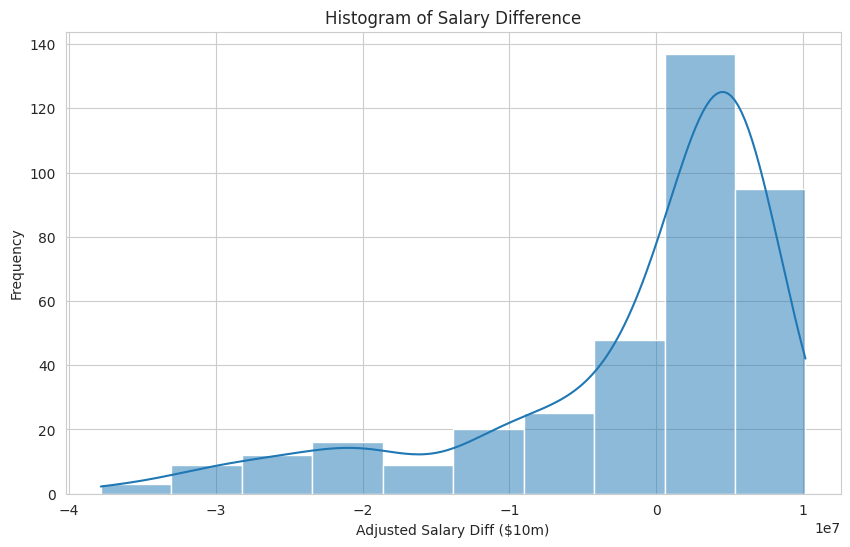

In [71]:
sns.set_style("whitegrid")

# Plotting the histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['adjusted_salary_diff'], bins=10, kde=True)

# Adding titles and labels
plt.title('Histogram of Salary Difference')
plt.xlabel('Adjusted Salary Diff ($10m)')
plt.ylabel('Frequency')

# Display the plot
plt.show()

With the adjusted salary, most players increased their salaries between 1 and 10 million.  A few select players salaries' decreased by over 30 million.

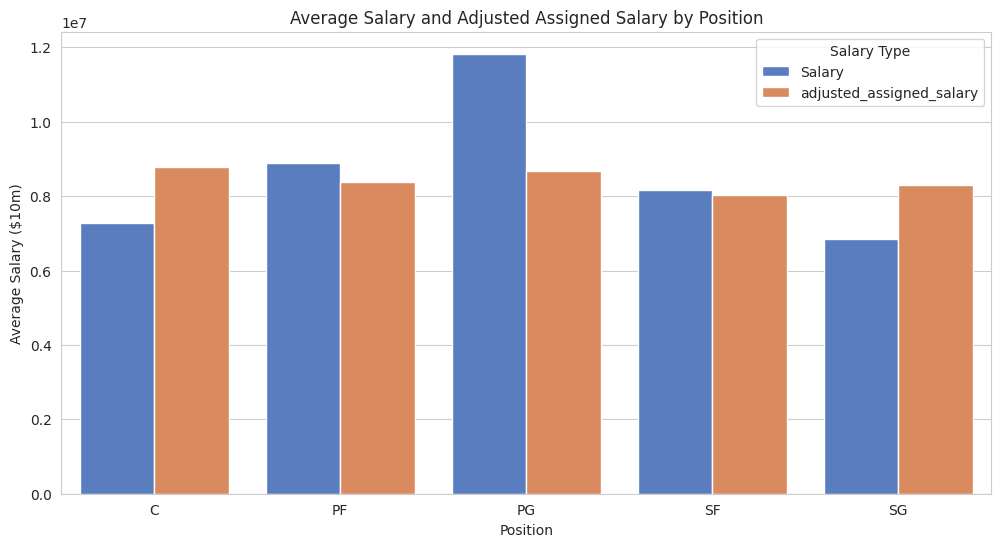

In [72]:
# Calculate the average salary and adjusted assigned salary by position
avg_salary_by_position = df.groupby('Position')[['Salary', 'adjusted_assigned_salary']].mean().reset_index()

# Reshape the data for plotting
avg_salary_melted = avg_salary_by_position.melt(id_vars='Position', var_name='Salary_Type', value_name='Average_Salary')

# Plotting the dodged bar chart using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='Position', y='Average_Salary', hue='Salary_Type', data=avg_salary_melted, palette='muted')

# Adding titles and labels
plt.title('Average Salary and Adjusted Assigned Salary by Position')
plt.xlabel('Position')
plt.ylabel('Average Salary ($10m)')
plt.legend(title='Salary Type')

# Display the plot
plt.show()

This approach suggests significantly reducing the salaries of point guards, while centers and shooting guards should see increased pay. Power forwards and small forwards would have slight decreases.

In [73]:
# Filter by GP >= 21 (approx 25% of the season)
df_filtered = df[df['GP'] >= 21]

# Function to get top 3 players with the lowest salary_diff for each position
def get_top3_by_position(group):
    return group.nlargest(3, 'adjusted_salary_diff')

# Apply the function to each group (each position)
top3_by_position = df_filtered.groupby('Position').apply(get_top3_by_position).reset_index(drop=True)

print(top3_by_position)

         Player Name   Salary Position     Team  GP    MP  3PA    3P%  2PA  \
0         Luka Garza   508891        C      MIN  28   8.7  1.4  0.359  2.8   
1        Moses Brown   824041        C  BRK/LAC  36   8.2  0.0  0.000  2.7   
2           Naz Reid  1930681        C      MIN  68  18.4  3.2  0.346  5.3   
3      Chimezie Metu  1910860       PF      SAC  66  10.4  0.6  0.237  2.7   
4   Keita Bates-Diop  1878720       PF      SAS  67  21.7  2.1  0.394  4.8   
5    Dominick Barlow   508891       PF      SAS  28  14.6  0.1  0.000  2.9   
6          Kris Dunn  1000001       PG      UTA  22  25.8  1.6  0.472  8.2   
7      Dalano Banton  1563518       PG      TOR  31   9.0  1.6  0.294  2.5   
8          Tre Jones  1782621       PG      SAS  68  29.2  2.3  0.285  8.6   
9       Anthony Lamb   694878       SF      GSW  62  19.3  3.2  0.367  1.9   
10    Eugene Omoruyi  1013119       SF  DET/OKC  40  16.1  2.2  0.281  3.5   
11     Jabari Walker  1017781       SF      POR  56  11.1  1.0  

/tmp/ipython-input-73-126351095.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top3_by_position = df_filtered.groupby('Position').apply(get_top3_by_position).reset_index(drop=True)


In [74]:
# Keep only the specified columns
top3_by_position = top3_by_position[['Player Name', 'Position', 'MP', 'PTS', 'Salary', 'adjusted_assigned_salary', 'adjusted_salary_diff']]

print(top3_by_position)

         Player Name Position    MP   PTS   Salary  adjusted_assigned_salary  \
0         Luka Garza        C   8.7   6.5   508891              1.066221e+07   
1        Moses Brown        C   8.2   4.3   824041              1.080183e+07   
2           Naz Reid        C  18.4  11.5  1930681              1.012837e+07   
3      Chimezie Metu       PF  10.4   4.9  1910860              9.306059e+06   
4   Keita Bates-Diop       PF  21.7   9.7  1878720              8.827623e+06   
5    Dominick Barlow       PF  14.6   3.9   508891              7.363488e+06   
6          Kris Dunn       PG  25.8  13.2  1000001              1.006595e+07   
7      Dalano Banton       PG   9.0   4.6  1563518              9.302482e+06   
8          Tre Jones       PG  29.2  12.9  1782621              9.513325e+06   
9       Anthony Lamb       SF  19.3   6.7   694878              7.427054e+06   
10    Eugene Omoruyi       SF  16.1   7.0  1013119              7.561468e+06   
11     Jabari Walker       SF  11.1   3.

This table shows the top 3 players at each position who overperform for their salaries. These players could be targets for acquisition.

In [75]:
# print the top
df_sorted = df_filtered.sort_values(by='adjusted_salary_diff', ascending=False)

df_sorted_select = df_sorted[['Player Name', 'Position', 'MP', 'PTS', 'Salary', 'adjusted_assigned_salary', 'adjusted_salary_diff']]

print(df_sorted_select.head(15))

               Player Name Position    MP   PTS   Salary  \
418             Luka Garza        C   8.7   6.5   508891   
395            Moses Brown        C   8.2   4.3   824041   
391              Kris Dunn       PG  25.8  13.2  1000001   
309           Desmond Bane       SG  31.7  21.5  2130240   
330               Naz Reid        C  18.4  11.5  1930681   
385            Jaden Hardy       SG  14.8   8.8  1017781   
324          Thomas Bryant        C  18.3   9.8  1968175   
382  Sandro Mamukelashvili        C  15.3   6.1  1116112   
376          Dalano Banton       PG   9.0   4.6  1563518   
353              Tre Jones       PG  29.2  12.9  1782621   
298           Bones Hyland       PG  19.4  11.8  2201520   
245         Andre Drummond        C  12.7   6.0  3200000   
379         Jordan Goodwin       PG  17.8   6.6  1280206   
349          Nick Richards        C  18.7   8.2  1782621   
374           Jock Landale        C  14.2   6.6  1563518   

     adjusted_assigned_salary  adjusted

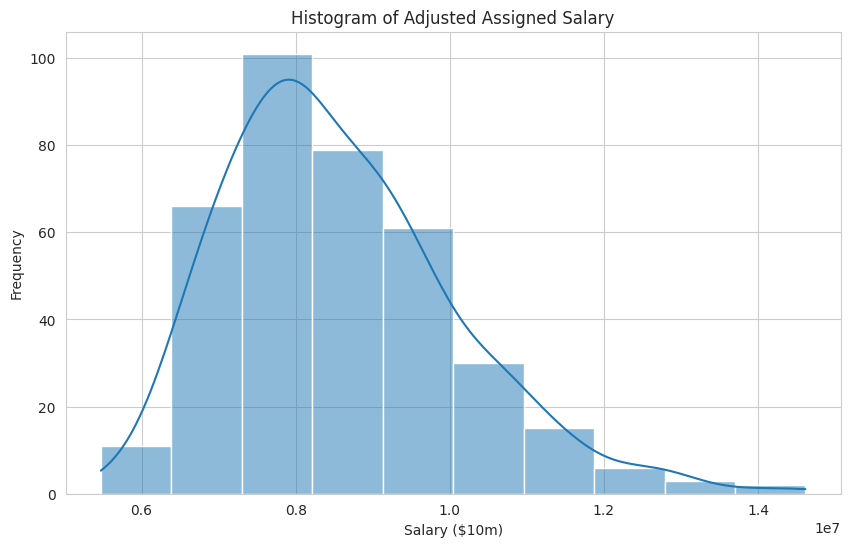

In [76]:
sns.set_style("whitegrid")

# Plotting the histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['adjusted_assigned_salary'], bins=10, kde=True)

# Adding titles and labels
plt.title('Histogram of Adjusted Assigned Salary')
plt.xlabel('Salary ($10m)')
plt.ylabel('Frequency')

# Display the plot
plt.show()

The distribution of salaries using the interpolation differs greatly from the actual distribution.

The curve is more normally distributed, although it slightly skews to the right.

The majority of players make between 8 and 10 million, and the highest salary is around 14 million.

# Conclusions

1. Predicting salary on statistics is not accurate. This could be for a number of reasons, including maximum and minimums imposed by the collective bargaining agreement based on years of experience, draft selection spot, and other factors. Also, salary negotiations are based on past experiences and may have been set several years before the season in which the player is paid that amount. Player performance can change drastically (either improve or decline) over the years, so their current performance may not align with their current salary.

2. Since teams need several players to contribute if they want to win games and championships, identifying overperforming/underpaid players can help build a winning team in a league with salary cap limitations. The false negatives in the xgboost model identified players whose stats indicate they are in the top 25% of players, but they were not paid in the top 25% in this season.

3. Assigning salaries based on performances results in a highly altered distribution of salaries. This indicates that the highest paid players are probably overpaid, and many lower tier players should earn more than they are. The adjustments also indicate point guards are highly valued (with high salaries), but their statistics may not justify this. Centers are often underpaid, according to this model.

# Caveats

1. This analysis only considers one season of data. More data would create more comprehensive and reliable conclusions.

2. The performance metric (PM_stats) created for this study is one way of quantifying performance. Other existing metrics, such as RAPTOR, could prove useful in this type of evaluation.

3. Other stats, such as plus/minus, which was not included in this dataset, or eFG%, which was dropped from this study, could also provide valuable insight in player evaluation.

4. A future study could include team-level analysis and consider the team's records. While stats capture much of how a player contributes to a team's success, team sports include intangibles that propell a team to victory that can't be easily be quantified. Taking into account a player's presence on a winning team could be important.